Aquí irá el portafolio de Blumenkron

#Introducción

Los incendios forestales han sido un fenómeno que ha afectado de diversas maneras a las personas al rededor del mundo

In [1]:
import os, shutil, pathlib
from tensorflow import keras #type: ignore
from keras.utils import to_categorical #type: ignore
from keras.utils import image_dataset_from_directory #type: ignore
from keras.models import Sequential #type: ignore
from keras.callbacks import EarlyStopping, ModelCheckpoint #type: ignore
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, RandomFlip, RandomZoom, RandomRotation, RandomContrast, Rescaling, GlobalMaxPooling2D #type: ignore
from keras.optimizers import Adam #type: ignore
from keras.regularizers import l2 #type: ignore
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

class_names = ["Battery","Glass","Metal","Organic","Paper","Plastic"]

base_dir = pathlib.Path("ImagenesOrdenadas")


train_dataset = image_dataset_from_directory(
    base_dir / "train",
    image_size=(224, 224),
    batch_size=32,
   label_mode="int",
    )

validation_dataset = image_dataset_from_directory(
    base_dir / "validation",
    image_size=(224, 224),
    batch_size=32,
    label_mode="int")

test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size=(224, 224),
    batch_size=32,
    label_mode="int")


Found 3252 files belonging to 6 classes.
Found 696 files belonging to 6 classes.
Found 702 files belonging to 6 classes.


2024-11-06 00:38:28.126370: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


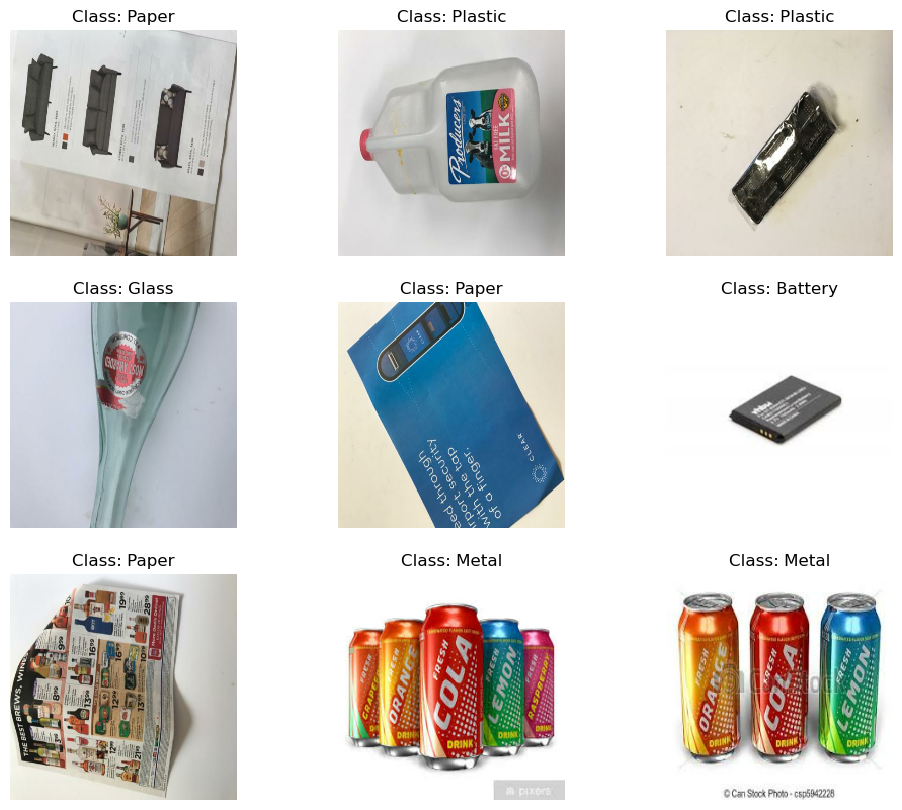

In [2]:
plt.figure(figsize=(12, 10))
index = 0
for element in train_dataset.take(1):
  for i in range(9):
    image = element[0][i]
    label = element[1][i]
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image/255, interpolation="nearest")
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

PRIMERO SE HACE LA RESIDUAL UNIT PARA EVITAR EL PROBLEMA DE LA DEGRADACIÓN que ocurre cuando un modelo profundo empeora su rendimiento debido a una pérdida de información en las capas.

In [3]:
class ResidualUnit(keras.layers.Layer): # Extend base Layer class
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs) # Call Layer's init
        self.activation = keras.activations.get(activation) # Get activation layer
        self.main_layers = [
            keras.layers.SeparableConv2D(filters, 3, strides=strides,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.SeparableConv2D(filters, 3, strides=1,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1: # Resize input if needed
            self.skip_layers = [
                keras.layers.SeparableConv2D(filters, 1, strides=strides,
                                    padding="same", use_bias=False),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [5]:
def modelo_cnn(input_shape=(224, 224, 3), num_classes=6):
    model = Sequential()

    model.add(RandomFlip("horizontal_and_vertical", input_shape=input_shape))
    model.add(RandomRotation(0.2))
    model.add(RandomZoom(0.2))
    model.add(RandomContrast(0.2))
    model.add(Rescaling(1./255))

    model.add(Conv2D(32, (3, 3), activation='relu',kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu',kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu',kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    prev_filters = 128
    for filters in [128] * 4 + [256] * 6 + [512] * 3:
        strides = 1 if filters == prev_filters else 2
        model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters
    
    # Aplanamiento de las características
    model.add(GlobalAveragePooling2D())

    # Capa completamente conectada
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Capa de salida
    model.add(Dense(num_classes, activation='softmax'))

    return model

modelo = modelo_cnn(input_shape=(224, 224, 3), num_classes=6)
modelo.summary()


/Users/gustavogutierrez/miniconda3/envs/Ambiente-Conda/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit (ResidualUnit)    │ (None, 26, 26, 128)    │        36,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_1 (ResidualUnit)  │ (None, 26, 26, 128)    │        36,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_2 (ResidualUnit)  │ (None, 26, 26, 128)    │        36,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_3 (ResidualUnit)  │ (None, 26, 26, 128)    │        36,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_4 (ResidualUnit)  │ (None, 13, 13, 256)    │       137,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_5 (ResidualUnit)  │ (None, 13, 13, 256)    │       137,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_6 (ResidualUnit)  │ (None, 13, 13, 256)    │       137,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_7 (ResidualUnit)  │ (None, 13, 13, 256)    │       137,728 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,744,134 (10.47 MB)

 Trainable params: 2,727,814 (10.41 MB)

 Non-trainable params: 16,320 (63.75 KB)

In [7]:
modelo.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:

early_stopper = EarlyStopping(
    monitor='val_loss', 
    patience=3,          
    restore_best_weights=True  
)

# Entrenar el modelo
history = modelo.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[early_stopper]
)


Epoch 1/20
 14/102 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - accuracy: 0.1771 - loss: 5.1964

KeyboardInterrupt: 

In [9]:
import matplotlib.pyplot as plt

# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


NameError: name 'history' is not defined

In [ ]:
predictions = modelo.predict(test_dataset)

predicted_classes = predictions.argmax(axis=1)

22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 389ms/step


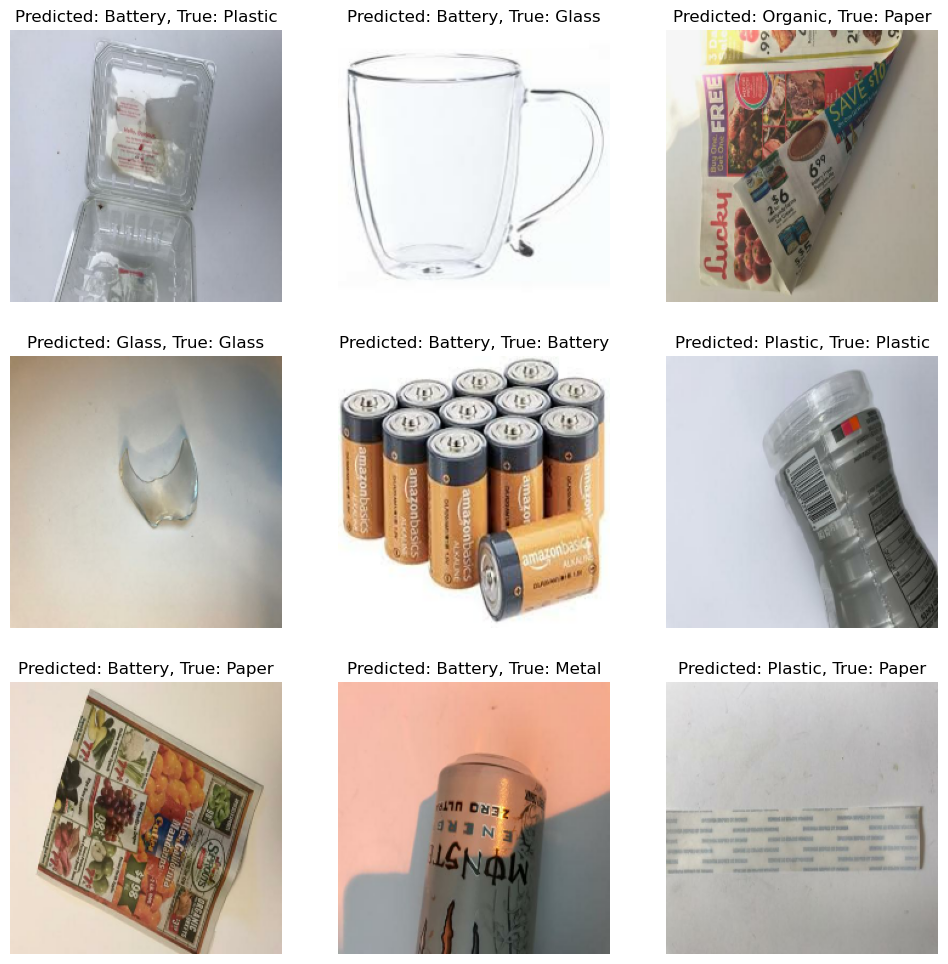

In [ ]:
def plot_predictions(dataset, predicted_classes, class_names):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            
            # Cambiar la forma en que se muestra la clase predicha y la verdadera
            plt.title(f"Predicted: {class_names[predicted_classes[i]]}, True: {class_names[labels[i]]}")
            plt.axis("off")
    plt.show()

# Visualizar algunas predicciones
plot_predictions(test_dataset, predicted_classes, class_names)

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = modelo.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 371ms/step - accuracy: 0.3749 - loss: 1.6237
Test Loss: 1.6253411769866943, Test Accuracy: 0.3817663788795471


Ahora se harán algunas modificaciones al modelo para obtener mejores resultados

-Se le agregaron dos capas convolucionales mas (254,512)
-Ahora la capa Dense tiene 256 neuronas
-Adam con learning rate de 0.0001
-Dropout a 0.7
-Aumentar patience de early 
-Implementación de regularización l2 en capas de conv2d

Opté por mas capas de Rsidual en lugar de L2 regualirization porque esta última es mejor en modelos más simples, pero tareas como desvanecimiento de gradientes o de aprendizaje no las puede abordar eficazmente en redes profundas. Si se utilizaran solo L2, se estaría propiciando a que el modelo aprenda representaciones más superficiales.

In [12]:
def modelo_cnn_mejorado(input_shape=(224, 224, 3), num_classes=6):
    model = Sequential()
    
    model.add(RandomFlip("horizontal_and_vertical",input_shape=input_shape))
    model.add(RandomRotation(0.4))
    model.add(RandomZoom(0.4))

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape,padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    model.add(ResidualUnit(128, strides=1))
    model.add(ResidualUnit(128, strides=1))
    model.add(ResidualUnit(256, strides=2))
    model.add(ResidualUnit(256, strides=1))
    model.add(ResidualUnit(512, strides=2))
    
    
    model.add(GlobalAveragePooling2D())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    return model

model_final = modelo_cnn_mejorado(input_shape=(224, 224, 3), num_classes=6)
model_final.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_18 (ResidualUnit) │ (None, 28, 28, 128)    │        36,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_19 (ResidualUnit) │ (None, 28, 28, 128)    │        36,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_20 (ResidualUnit) │ (None, 14, 14, 256)    │       137,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_21 (ResidualUnit) │ (None, 14, 14, 256)    │       137,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_22 (ResidualUnit) │ (None, 7, 7, 512)      │       537,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,112,262 (4.24 MB)

 Trainable params: 1,105,158 (4.22 MB)

 Non-trainable params: 7,104 (27.75 KB)

In [13]:
model_final.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model_final.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=15,
    callbacks=[early_stopper]
)

Epoch 1/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.3796 - loss: 1.5666 - val_accuracy: 0.1724 - val_loss: 1.7900
Epoch 2/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.5562 - loss: 1.1694 - val_accuracy: 0.1710 - val_loss: 1.7871
Epoch 3/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.6035 - loss: 1.0592 - val_accuracy: 0.1882 - val_loss: 1.7699
Epoch 4/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.6387 - loss: 0.9827 - val_accuracy: 0.2270 - val_loss: 1.6839
Epoch 5/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.6534 - loss: 0.9451 - val_accuracy: 0.3779 - val_loss: 1.4566
Epoch 6/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1964s 19s/step - accuracy: 0.6582 - loss: 0.9273 - val_accuracy: 0.5833 - val_loss: 1.0420
Epoch 7/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 5097s 50s/step - accuracy: 0.6762 - loss: 0.8888 - val_accuracy: 0.7069 - val_loss: 0.8142
Epoch 8/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 5895s 58s/step - accuracy: 0.6745 - loss: 0.8572 - va

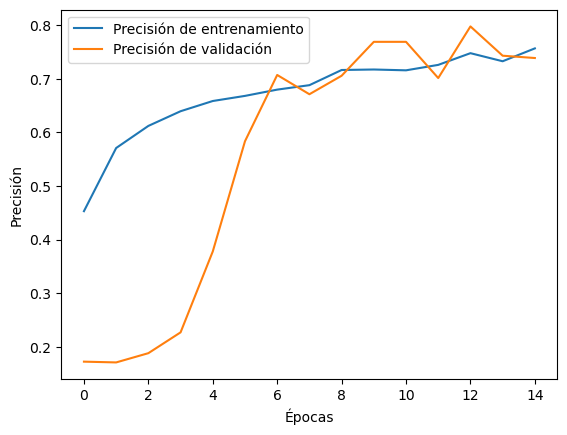

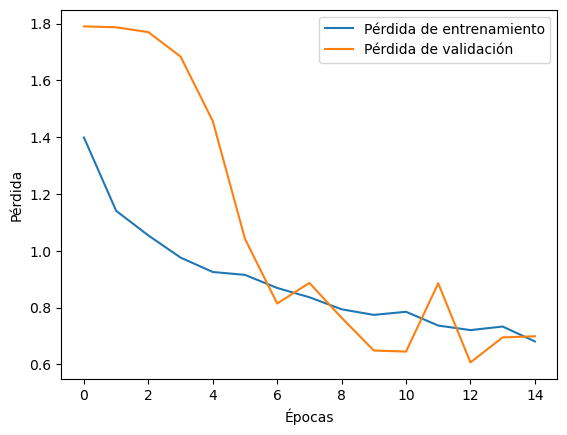

In [14]:
# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [18]:
predictions = model_final.predict(test_dataset)

predicted_classes = predictions.argmax(axis=1)

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step


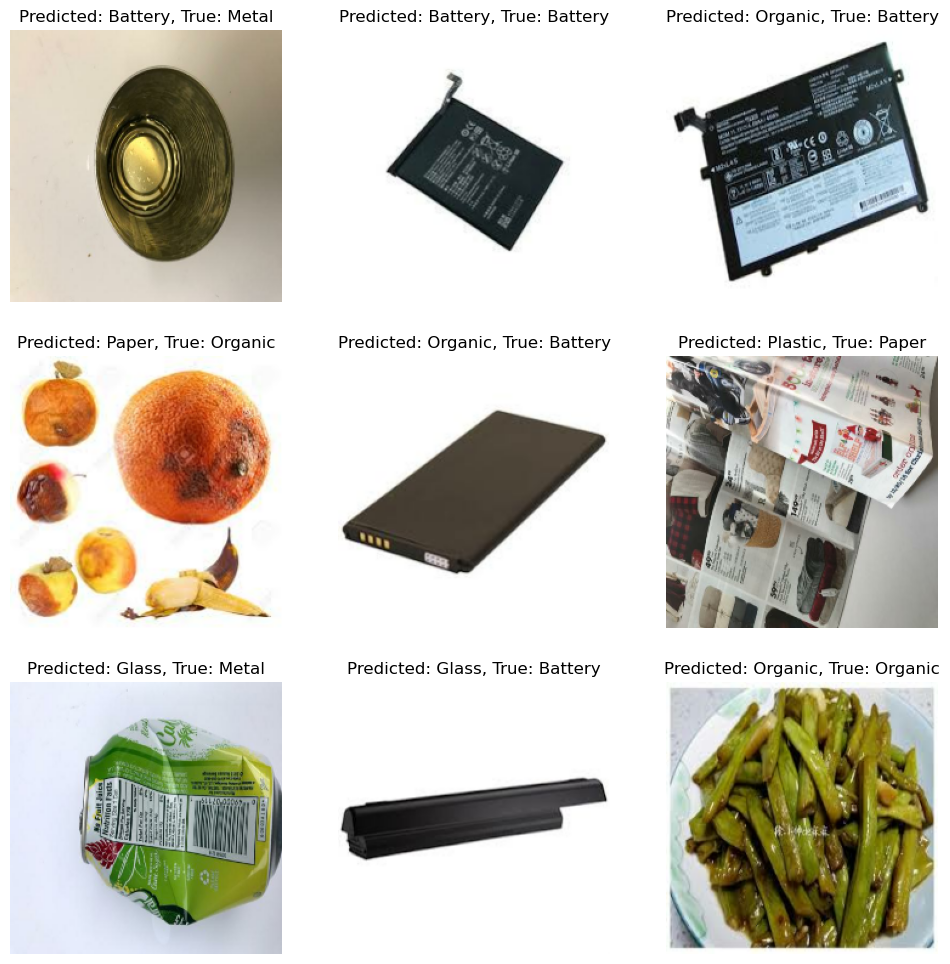

In [19]:
def plot_predictions(dataset, predicted_classes, class_names):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            
            # Cambiar la forma en que se muestra la clase predicha y la verdadera
            plt.title(f"Predicted: {class_names[predicted_classes[i]]}, True: {class_names[labels[i]]}")
            plt.axis("off")
    plt.show()

# Visualizar algunas predicciones
plot_predictions(test_dataset, predicted_classes, class_names)

In [20]:
test_loss, test_accuracy = model_final.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.7836 - loss: 0.6668
Test Loss: 0.6870009899139404, Test Accuracy: 0.7621082663536072
